In [1]:
library(nlme)
library(multcomp)
options(jupyter.plot_mimetypes = "image/png")
library(ggplot2)
library(corrplot)
library(gridExtra)
library(grid)
library(data.table)
library(effects)
library(xtable)
library(reshape)

Loading required package: mvtnorm
Loading required package: survival
Loading required package: TH.data
Loading required package: MASS

Attaching package: ‘TH.data’

The following object is masked from ‘package:MASS’:

    geyser

Warning message:
“package ‘corrplot’ was built under R version 3.4.2”corrplot 0.84 loaded
Loading required package: carData
lattice theme set by effectsTheme()
See ?effectsTheme for details.

Attaching package: ‘reshape’

The following object is masked from ‘package:data.table’:

    melt



# Load Data

In [3]:
data = read.csv("../data_meta_analysis/Data_Classifications_v8b.csv")

In [5]:
data<-data[c('PID','Info.type','Accuracy.50','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing',
             'Coregistration','Pattern.normalization.type','Num_subs','Voxel.numbers',
             'Resolution','Training.setsize')]

factors<-c('Info.type','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing',
           'Coregistration','Pattern.normalization.type','Num_subs','Voxel.numbers',
             'Resolution','Training.setsize')

In [6]:
R4 = read.csv(paste("../data_meta_analysis/data_derived_meta_analysis/X_region1_after_clustering2_v8b.csv"))

R4names = colnames(R4)
i=1
for (name in R4names){
    R4names[i]<-paste(sep='','R4',name)
    i=i+1
}
R4names
colnames(R4)<-R4names
head(R4)

[1] "R4Frontal_Sup" "R4Frontal_Mid" "R4Frontal_Inf" "R4Frontal_Orb"
[5] "R4Insula"      "R4Motor"       "R4Cingulum"

R4Frontal_Sup,R4Frontal_Mid,R4Frontal_Inf,R4Frontal_Orb,R4Insula,R4Motor,R4Cingulum
0,0,1,0,0,0,0
0,0,0,0,1,0,0
0,0,1,0,0,0,0
0,0,0,0,1,0,0
0,0,1,0,0,0,0
0,0,0,0,1,0,0


In [7]:
nrow(R4)
nrow(data)

[1] 891

[1] 891

In [8]:
data = cbind(data,R4) # will bind with other region names too 


# mscl fixed 
data<-data[!data$Classifier.type=='neural-net',] # no observations but still has a level
data[data$Scanner=='4T','Scanner']='3T' # only one observatoin with 3T

data$PID<-as.factor(data$PID)
data$Info.type<-as.factor(data$Info.type)
data$Smoothing<-as.factor(data$Smoothing)
data$Roi.Search<-as.factor(data$Roi.Search)
data$Classifier.type<-as.factor(data$Classifier.type)
data$Coregistration<-as.factor(data$Coregistration)
data$Pattern.type<-as.factor(data$Pattern.type)
data$Pattern.normalization.type<-as.factor(data$Pattern.normalization.type)

# droplevels
data<-droplevels(data)

# sig / non sig split 
data_50<-subset(data,!is.na(Accuracy.50))
data_50_non<-subset(data,!is.na(Accuracy.50)& Significance==0)
data_50_sig<-subset(data,!is.na(Accuracy.50) & Significance==1)
head(data_50_sig)
nrow(data_50_sig)



,PID,Info.type,Accuracy.50,Significance,Roi.Search,Pattern.type,Classifier.type,Scanner,Smoothing,Coregistration,⋯,Voxel.numbers,Resolution,Training.setsize,R4Frontal_Sup,R4Frontal_Mid,R4Frontal_Inf,R4Frontal_Orb,R4Insula,R4Motor,R4Cingulum
4,1,Perceptual,0.528,1,ROI,Multi-Trial Multi-Time Point,svm-lin,3T,unsmooth,Native Space,⋯,111,3mmx3mmx3.75mm,36,0,0,0,0,1,0,0
9,1,Rule,0.535,1,ROI,Multi-Trial Multi-Time Point,svm-lin,3T,unsmooth,Native Space,⋯,111,3mmx3mmx3.75mm,36,0,0,0,0,1,0,0
10,1,Rule,0.541,1,ROI,Multi-Trial Multi-Time Point,svm-lin,3T,unsmooth,Native Space,⋯,630,3mmx3mmx3.75mm,36,0,0,1,0,0,0,0
11,1,Rule,0.543,1,ROI,Multi-Trial Multi-Time Point,svm-lin,3T,unsmooth,Native Space,⋯,111,3mmx3mmx3.75mm,36,0,0,0,0,1,0,0
12,1,Rule,0.593,1,ROI,Multi-Trial Multi-Time Point,svm-lin,3T,unsmooth,Native Space,⋯,315,3mmx3mmx3.75mm,36,0,0,1,0,0,0,0
16,2,Rule,0.640,1,ROI,Single Trial Multi-Time Point,LDA,3T,unsmooth,Native Space,⋯,140,3mmx3mmx4mm,98,0,0,0,0,0,1,0


[1] 512

In [9]:
#data[data$Info.type==levels(data$Info.type)[1],]
levels(data$Info.type)

[1] "Perceptual" "Response"   "Rule"       "Value"

# Just interaction model 

In [10]:
R1names_string<-c()
for (R in R4names){
    R1names_string<-paste(R1names_string,R,sep='+')
    
}
R1names_string<-substring(R1names_string, 2)
R1names_string

[1] "R4Frontal_Sup+R4Frontal_Mid+R4Frontal_Inf+R4Frontal_Orb+R4Insula+R4Motor+R4Cingulum"

In [11]:
d<-data_50_sig[c('Accuracy.50','PID','Info.type',R4names)]
gmean<-mean(d$Accuracy.50)
d$Accuracy.50_wo_gmean<-d$Accuracy.50-gmean
R1names_string2<-paste(R1names_string,')',sep='')
d$Info.type<-as.factor(d$Info.type)


In [12]:
# first model matrix # value as reference
d$Info.type=relevel(d$Info.type,ref='Value')
levels(d$Info.type)
region_model<-lme(as.formula(paste('Accuracy.50_wo_gmean~(',R1names_string2,'*Info.type',sep='')),random=~1|PID,data=d,method='REML')
X<-model.matrix(region_model,d)
X_interactions<-X[,12:ncol(X)]
#head(X_interactions)

[1] "Value"      "Perceptual" "Response"   "Rule"

In [13]:
# second one 
d$Info.type=relevel(d$Info.type,ref='Rule')
levels(d$Info.type)
region_model<-lme(as.formula(paste('Accuracy.50_wo_gmean~(',R1names_string2,'*Info.type',sep='')),random=~1|PID,data=d,method='REML')
X<-model.matrix(region_model,d)
X_interactions2<-X[,12:ncol(X)]
#head(X_interactions2)

[1] "Rule"       "Value"      "Perceptual" "Response"

In [14]:
#colnames(X_interactions2)
#colnames(X_interactions)

In [15]:

X_value<-X_interactions2[,c(1,4,7,10,13,16,19)]
X_perc<-X_interactions2[,c(2,5,8,11,14,17,20)]
X_resp<-X_interactions2[,c(3,6,9,12,15,18,21)]
X_rule<-X_interactions[,c(3,6,9,12,15,18,21)]
X_new<-data.frame(cbind(X_value,X_perc,X_resp,X_rule))
X_new<-as.matrix(X_new)


In [16]:
d<-data_50_sig[c('Accuracy.50','PID','Info.type',R4names)]
gmean<-mean(d$Accuracy.50)
d$Accuracy.50_wo_gmean<-d$Accuracy.50-gmean

region_model<-lme(Accuracy.50_wo_gmean~X_new,random=~1|PID,data=d,method='REML')
summary(region_model)$tTable

,Value,Std.Error,DF,t-value,p-value
(Intercept),-9.212979e-03,0.01367586,409,-0.673667394,0.500903311
X_newR4Frontal_Sup.Info.typeValue,6.707905e-03,0.01867972,409,0.359100860,0.719704949
X_newR4Frontal_Mid.Info.typeValue,-1.387175e-02,0.01804615,409,-0.768681890,0.442525803
X_newR4Frontal_Inf.Info.typeValue,-2.092714e-02,0.02350269,409,-0.890414494,0.373766823
X_newR4Frontal_Orb.Info.typeValue,4.732644e-03,0.02168791,409,0.218215803,0.827369807
X_newR4Insula.Info.typeValue,-2.035360e-02,0.05566493,409,-0.365644921,0.714819082
X_newR4Motor.Info.typeValue,-1.907246e-02,0.02078258,409,-0.917713894,0.359309513
X_newR4Cingulum.Info.typeValue,3.201838e-05,0.02302724,409,0.001390457,0.998891254
X_newR4Frontal_Sup.Info.typePerceptual,-1.710947e-02,0.01638549,409,-1.044184146,0.297016957
X_newR4Frontal_Mid.Info.typePerceptual,5.332713e-03,0.01710156,409,0.311826076,0.755331601


In [29]:
#round(0.034687448,2)
round(0.003659881,3)

[1] 0.004

In [17]:

# get data #
s<-summary(region_model)
coef<-s$tTable[,1] 
se<-s$tTable[,2] 
df<-data.frame(cbind(coef,se))

df$name<-rownames(df)
df<-df[2:nrow(df),] # remove intercept

In [18]:
df$coef_gmean <- df$coef+gmean
df

,coef,se,name,coef_gmean
X_newR4Frontal_Sup.Info.typeValue,6.707905e-03,0.01867972,X_newR4Frontal_Sup.Info.typeValue,0.6167702
X_newR4Frontal_Mid.Info.typeValue,-1.387175e-02,0.01804615,X_newR4Frontal_Mid.Info.typeValue,0.5961906
X_newR4Frontal_Inf.Info.typeValue,-2.092714e-02,0.02350269,X_newR4Frontal_Inf.Info.typeValue,0.5891352
X_newR4Frontal_Orb.Info.typeValue,4.732644e-03,0.02168791,X_newR4Frontal_Orb.Info.typeValue,0.6147949
X_newR4Insula.Info.typeValue,-2.035360e-02,0.05566493,X_newR4Insula.Info.typeValue,0.5897087
X_newR4Motor.Info.typeValue,-1.907246e-02,0.02078258,X_newR4Motor.Info.typeValue,0.5909898
X_newR4Cingulum.Info.typeValue,3.201838e-05,0.02302724,X_newR4Cingulum.Info.typeValue,0.6100943
X_newR4Frontal_Sup.Info.typePerceptual,-1.710947e-02,0.01638549,X_newR4Frontal_Sup.Info.typePerceptual,0.5929528
X_newR4Frontal_Mid.Info.typePerceptual,5.332713e-03,0.01710156,X_newR4Frontal_Mid.Info.typePerceptual,0.6153950
X_newR4Frontal_Inf.Info.typePerceptual,6.457793e-03,0.01532928,X_newR4Frontal_Inf.Info.typePerceptual,0.6165201


In [26]:
round(.6385667,3)
round(0.6565275,3)

[1] 0.639

[1] 0.657

In [19]:
# do some name changes for axis # 

cc<-c()
for (name in df$name){
    newname<-gsub("R4","",name)
    newname<-gsub("X_new","",newname)
    newname<-gsub("Info.type","",newname)
    newname<-gsub(".Rule"," (Rule)",newname)
    newname<-gsub(".Response"," (Response)",newname)
    newname<-gsub(".Perceptual"," (Perceptual)",newname)
    newname<-gsub(".Value"," (Value)",newname)
    newname<-gsub("Frontal_Sup","Superior frontal gyrus",newname)
    newname<-gsub("Frontal_Mid","Middle frontal gyrus",newname)
    newname<-gsub("Frontal_Inf","Inferior frontal gyrus",newname)
    newname<-gsub("Frontal_Orb","Superior & middle frontal gyrus, orbital part",newname)
    newname<-gsub("Insula","Insula",newname)
    newname<-gsub("Motor","Precentral gyrus & supplementary motory cortex",newname)
    newname<-gsub("Cingulum","Cingulate gyrus",newname)
    #newname<-gsub(".","_",newname)
    cc<-c(cc,newname)
    #print(newname)
    
}
df$name2<-cc

pdf 
  2

pdf 
  2

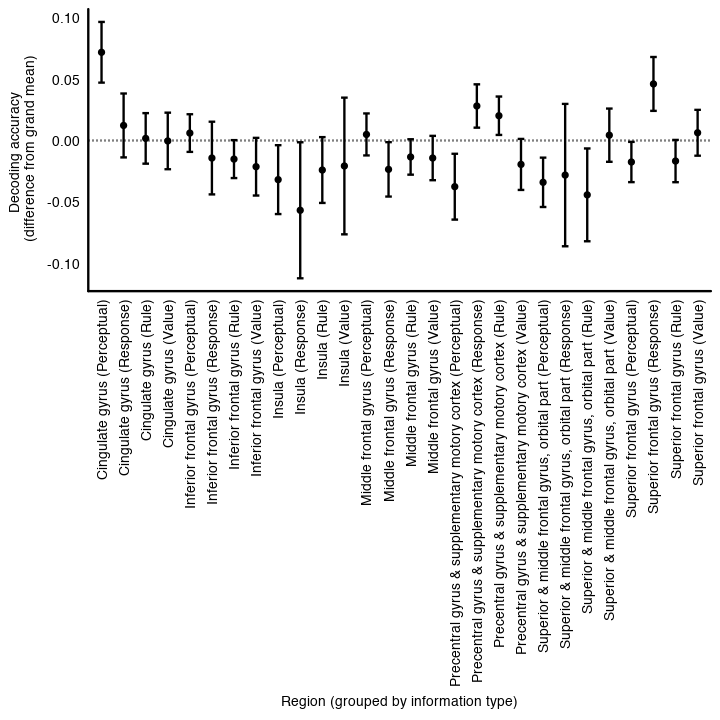

In [21]:



# main plot 
p<-ggplot(data=df,aes(x=name2))+
geom_point(aes(y=coef),size=1)+
geom_errorbar(aes(ymax = coef + se, ymin=coef- se),width=0.3)
p<-p+geom_hline(yintercept=0,linetype='dotted') 

mainlinewidth=.5
textsize = 8
labelsize = 8

# theme 
p<-p+xlab('Region (grouped by information type)')
p<-p+ylab('Decoding accuracy \n (difference from grand mean)')
p<-p+theme(panel.background=element_blank())


p<-p+theme(axis.line.x = element_line(color="black", size =mainlinewidth),
        axis.line.y = element_line(color="black", size = mainlinewidth))

p<-p+theme(axis.text.y = element_text(family="Helvetica",size=textsize,colour='black'))
p<-p+theme(axis.text.x = element_text(family="Helvetica",angle = 90, vjust=0.5,
                                      hjust = 1,size=textsize,colour='black'))
p<-p+theme(plot.title = element_text(family="Helvetica",size=labelsize,colour='black'))
p<-p+theme(axis.title.x = element_text(family="Helvetica",size=labelsize,colour='black'))
p<-p+theme(axis.title.y = element_text(family="Helvetica",size=labelsize,colour='black'))

p<-p+theme(axis.ticks.x=element_blank(),axis.ticks.y=element_blank())

setEPS()
postscript('../Figures/Supp_accuracy_by_region_info_interaction_v8b.eps',width=6,height=6)
p
dev.off()

png('../Figures/Supp_accuracy_by_region_info_interaction_v8b.png',width=6,height=6,
    units="in",res=400)
p
dev.off()
options(repr.plot.width=6, repr.plot.height=6)
p
